# ViT model with CLAHE

## Loading data and images

In [ ]:
import tensorflow as tf

print(tf.__version__)

#version of tensorflow needs to be 2.15.0 to be able to work with the ViT package of keras

2.15.0


In [ ]:
%reset -f

In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from random import randint
import albumentations as A
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
#mount my drive

from google.colab import drive

drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
#load images into the local disc of Google Collab for faster image loading

!unzip "/content/drive/My Drive/Thesis/images_by_AR.zip" -d "/content"

In [ ]:
#load in the split datasets from the EDA section

#the undersampled, subsetted datasets

train = pd.read_csv('/content/drive/My Drive/Thesis/train_us.csv')
test_us = pd.read_csv('/content/drive/My Drive/Thesis/test_us.csv')
test_imb = pd.read_csv('/content/drive/My Drive/Thesis/test_imbalanced.csv')
val = pd.read_csv('/content/drive/My Drive/Thesis/val_us.csv')

print (len(train))
print (len(val))
print (len(test_us))
print (len(test_imb))

74650
11243
9399
24175


## Making dataset with tf.data.Dataset

In [ ]:
#set up the augmentation pipeline
def augment (img):
  """Have the image augmented with random augmentation"""

  augmentations = A.Compose(
      [A.HorizontalFlip (p = 0.5),
       A.VerticalFlip(p=0.5),
       A.Rotate (limit=(-90,90), interpolation=cv.INTER_CUBIC, border_mode=cv.BORDER_REFLECT, p=0.5)]
  )

  augmented = augmentations(image=img)['image']

  return augmented

In [ ]:
#TRAIN SET
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

# Function to load and process images

def load_and_process_image(filename, label):
    # Decode the filename from bytes to string
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    # Read the image
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply CLAHE
    img = A.clahe(img, tile_grid_size=(8,8), clip_limit = 2.5)

    img = augment(img)

    img = img.astype ('float32')/255

    return img, label

# Create a tf.data.Dataset from the CSV
filenames = train['filename'].values
labels = train['class'].values

# Convert filenames and labels to TensorFlow Tensors
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Map the loading and processing function
def map_func(filename, label):
    img, label = load_and_process_image(filename.numpy(), label.numpy())
    return img, label

# Apply tf.py_function and explicitly set output shapes
dataset = dataset.map(
    lambda filename, label: tf.py_function(
        func=map_func, inp=[filename, label], Tout=[tf.float32, tf.int64]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

def set_shapes(img, label):
    img.set_shape((224, 224, 3))  # Set the shape for the image
    label.set_shape(())  # Set the shape for the label (scalar)
    return img, label

dataset = dataset.map(set_shapes)

# Batch and prefetch the dataset for performance
dataset = dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Test the dataset for shape consistency
for images, labels in dataset.take(1):
    print ('batch fetched')


batch fetched


In [ ]:
for images, labels in dataset.take(1):  # Only take the first batch
    min_pixel = tf.reduce_min(images)
    max_pixel = tf.reduce_max(images)
    print("Pixel range in the batch:")
    print("Min pixel value:", min_pixel.numpy())
    print("Max pixel value:", max_pixel.numpy())

Pixel range in the batch:
Min pixel value: 0.050980393
Max pixel value: 0.99607843


In [ ]:
#VAL SET

import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    #convert to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = A.clahe(img, tile_grid_size=(8,8), clip_limit = 2.5)

    img = img.astype('float32')/255

    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_val = val['filename'].values
labels_val = val['class'].values

#make the datasets (turns filenames and labels to tensors)
val_dataset = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
val_dataset = val_dataset.map(process_image_and_label_val)

val_dataset = val_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for batch in dataset.take(1):
    print("Batch input shape:", batch[0].shape)
    print("Batch target shape:", batch[1].shape)


Batch input shape: (64, 224, 224, 3)
Batch target shape: (64,)


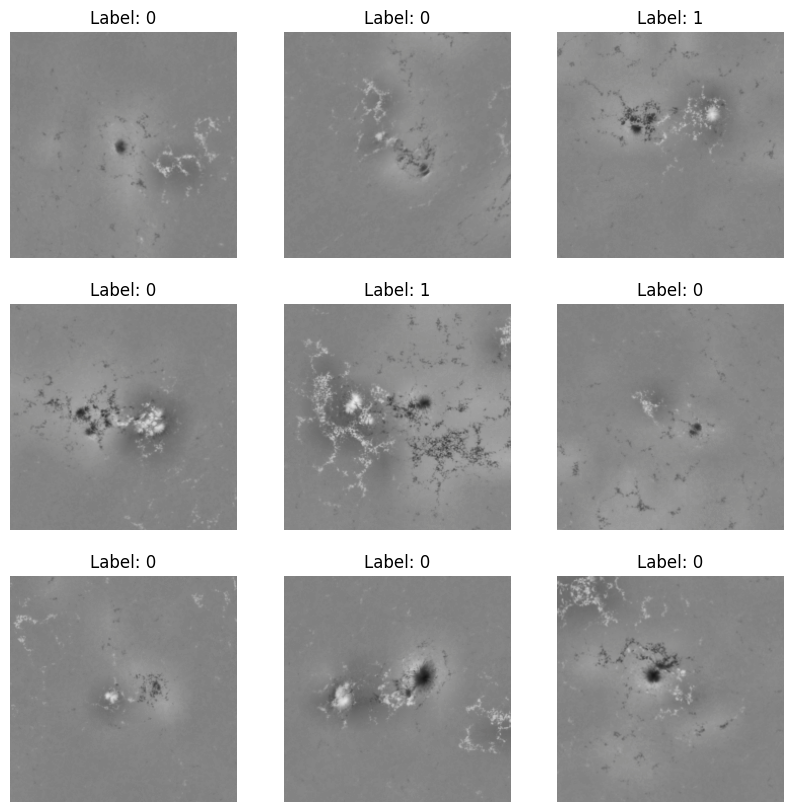

In [ ]:
import matplotlib.pyplot as plt

# Function to plot a grid of 9 images
def display_batch_of_images(images, labels):
    plt.figure(figsize=(10, 10))

    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")  # Hide axes

    plt.show()

# Fetch one batch of images and labels
for images, labels in dataset.take(1):
    # Since the dataset is batched, we take the first batch and display it
    display_batch_of_images(images, labels)
    break



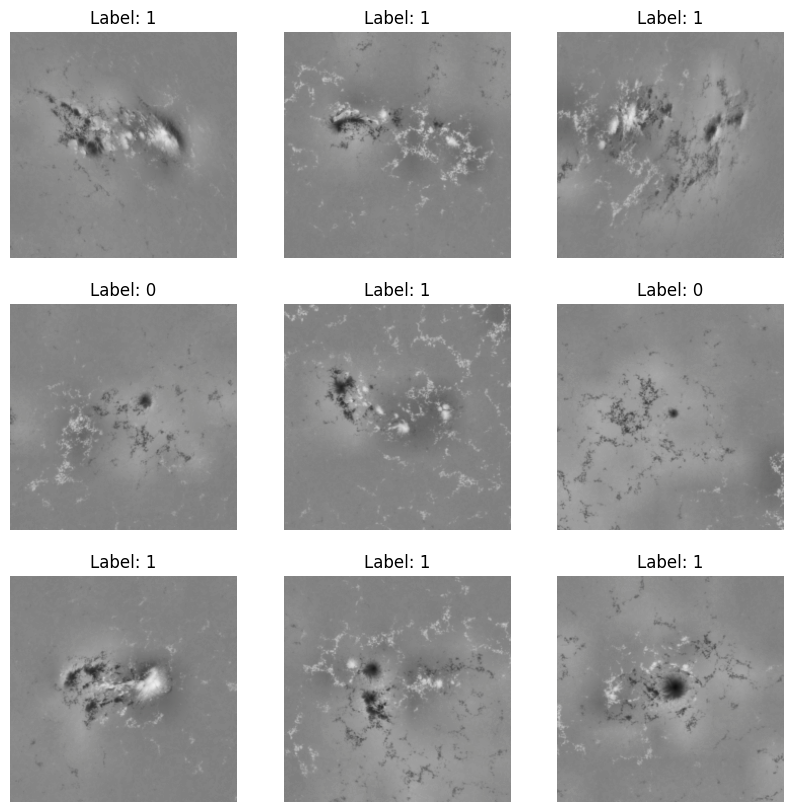

In [ ]:
for images, labels in val_dataset.take(1):
    # Since the dataset is batched, we take the first batch and display it
    display_batch_of_images(images, labels)
    break

## ViT loading

In [ ]:
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from vit_keras import vit

vit = vit.vit_b16(image_size=(224,224), activation="sigmoid", pretrained=True,
                            include_top=False, pretrained_top=False)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 9s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
for layers in vit.layers:
  layers.trainable = False

vit.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers

for layer in vit.layers:
    layer.trainable = False

#unfreeze last layer
for layer in vit.layers[-2:]:
    layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3))
x = vit(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  #add classification head
model = models.Model (inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_113 (Dropout)       (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 769       
                                                                 
Total params: 85799425 (327.30 MB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 85797120 (327.29 MB)
_________________________________________________________________


In [ ]:
import keras
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

In [ ]:
import keras
import tensorflow as tf

loss = tf.keras.losses.BinaryCrossentropy()

#learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              #patience=5, min_lr=0.000001)

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00001, weight_decay = 0.001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', precision, recall])

In [ ]:
history = model.fit (dataset, validation_data = val_dataset, epochs = 20,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=15),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/best_ViT_clahe.keras', save_best_only=True)
                    ], verbose = 1)

#model might need more complexity
#model might need some extra epochs to converge, not done converging

Epoch 1/20
1167/1167 [==============================] - 1625s 1s/step - loss: 0.7779 - accuracy: 0.5436 - precision_1: 0.5436 - recall_1: 0.5431 - val_loss: 0.6832 - val_accuracy: 0.5871 - val_precision_1: 0.5827 - val_recall_1: 0.6140
Epoch 2/20
1167/1167 [==============================] - 1592s 1s/step - loss: 0.7175 - accuracy: 0.5860 - precision_1: 0.5856 - recall_1: 0.5884 - val_loss: 0.6376 - val_accuracy: 0.6349 - val_precision_1: 0.6289 - val_recall_1: 0.6581
Epoch 3/20
1167/1167 [==============================] - 1601s 1s/step - loss: 0.6824 - accuracy: 0.6150 - precision_1: 0.6140 - recall_1: 0.6192 - val_loss: 0.6084 - val_accuracy: 0.6670 - val_precision_1: 0.6668 - val_recall_1: 0.6677
Epoch 4/20
1167/1167 [==============================] - 1606s 1s/step - loss: 0.6606 - accuracy: 0.6361 - precision_1: 0.6350 - recall_1: 0.6401 - val_loss: 0.5882 - val_accuracy: 0.6818 - val_precision_1: 0.6823 - val_recall_1: 0.6807
Epoch 5/20
1167/1167 [==============================] - 

## Same model, but starting with a higher learning rate, and an added MLP layer

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers

for layer in vit.layers:
    layer.trainable = False

#unfreeze last layer
for layer in vit.layers[-2:]:
    layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3))
x = vit(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  #add classification head
model = models.Model (inputs, outputs)

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dense_11 (Dense)            (None, 128)               98432     
                                                                 
 dropout_191 (Dropout)       (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 85897217 (327.67 MB)
Trainable params: 100097 (391.00 KB)
Non-trainable params: 85797120 (327.29 MB)
_________________________________________________________________


In [ ]:
import keras
import tensorflow as tf

loss = tf.keras.losses.BinaryCrossentropy()

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay = 0.001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', precision, recall])

In [ ]:
#start with 20 epochs

history = model.fit (dataset, validation_data = val_dataset, epochs = 20,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=15),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/best_ViT_clahe_3.keras', save_best_only=True),
                        learning_rate_s
                    ], verbose = 1)

history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_3.csv')

#Does not add significant improvement to the model

Epoch 1/20
1167/1167 [==============================] - 1582s 1s/step - loss: 0.4775 - accuracy: 0.7695 - precision_1: 0.7744 - recall_1: 0.7631 - val_loss: 0.5431 - val_accuracy: 0.7368 - val_precision_1: 0.8328 - val_recall_1: 0.5927 - lr: 1.0000e-04
Epoch 2/20
1167/1167 [==============================] - 1574s 1s/step - loss: 0.4638 - accuracy: 0.7781 - precision_1: 0.7796 - recall_1: 0.7754 - val_loss: 0.5637 - val_accuracy: 0.7373 - val_precision_1: 0.8388 - val_recall_1: 0.5877 - lr: 1.0000e-04
Epoch 3/20
1167/1167 [==============================] - 1579s 1s/step - loss: 0.4606 - accuracy: 0.7803 - precision_1: 0.7806 - recall_1: 0.7798 - val_loss: 0.5637 - val_accuracy: 0.7368 - val_precision_1: 0.8348 - val_recall_1: 0.5905 - lr: 1.0000e-04
Epoch 4/20
1167/1167 [==============================] - 1584s 1s/step - loss: 0.4597 - accuracy: 0.7787 - precision_1: 0.7796 - recall_1: 0.7772 - val_loss: 0.5696 - val_accuracy: 0.7330 - val_precision_1: 0.8359 - val_recall_1: 0.5799 - lr:

## Last transformer block unfrozen

I unfroze another layer, the last transformer block, so the model can fine-tune better on the specific data. I also made the learning rate higher to (hopefully) speed up convergence, as well as a higher batch size (128). LR = 0.0001 with ReduceOnPlateau turned on, so the LR does not get too high.

Because the model is becoming more complex, I took pretty strong measures to prevent overfitting. ViTs are more prone to this.

- Low lr (0.00001)
- Label smoothing = 0.1
- Dropout = 0.4
- L2 regularizer = 0.0001
- Weight decay = 0.001
- Keeping the batch size on the lower end (64)

NOTE: due to running the same cell with different settings, the output of some of the experiments are lost and only the last one remains. Other experiments with adding complexity all showed overfitting signs with validation loss and accuracy not improving once in the model.

In [ ]:
for layers in vit.layers:
  layers.trainable = False

from tensorflow.keras import layers, models

for layer in vit.layers:
    layer.trainable = False

#unfreeze last layer
for layer in vit.layers[-3:]:
    layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3))
x = vit(inputs)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(0.0001))(x)  #add classification head
model = models.Model (inputs, outputs)
model.summary()

#adding stronger overfitting prevention

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_116 (Dropout)       (None, 768)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 769       
                                                                 
Total params: 85799425 (327.30 MB)
Trainable params: 7090177 (27.05 MB)
Non-trainable params: 78709248 (300.25 MB)
_________________________________________________________________


In [ ]:
import keras
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

In [ ]:
#starting of with a higher learning rate

import keras
import tensorflow as tf

loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.0000001)

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00001, weight_decay = 0.001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', precision, recall])

In [ ]:
history = model.fit (dataset, validation_data = val_dataset, epochs = 20,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=15),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/best_ViT_clahe_2.keras', save_best_only=True),
                        learning_rate_s
                    ], verbose = 1)

history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_2.csv')

#seems to be on the overfitting trend as well, and the model's val_recall is very very poor, while recall should be as high as possible

Epoch 1/20
1167/1167 [==============================] - 1743s 1s/step - loss: 0.5692 - accuracy: 0.7310 - precision_1: 0.7320 - recall_1: 0.7288 - val_loss: 0.5696 - val_accuracy: 0.7350 - val_precision_1: 0.8315 - val_recall_1: 0.5896 - lr: 1.0000e-05
Epoch 2/20
1167/1167 [==============================] - 1714s 1s/step - loss: 0.5368 - accuracy: 0.7642 - precision_1: 0.7688 - recall_1: 0.7557 - val_loss: 0.5803 - val_accuracy: 0.7319 - val_precision_1: 0.8368 - val_recall_1: 0.5763 - lr: 1.0000e-05
Epoch 3/20
1167/1167 [==============================] - 1694s 1s/step - loss: 0.5297 - accuracy: 0.7693 - precision_1: 0.7746 - recall_1: 0.7597 - val_loss: 0.5830 - val_accuracy: 0.7317 - val_precision_1: 0.8367 - val_recall_1: 0.5760 - lr: 1.0000e-05
Epoch 4/20
1003/1167 [========================>.....] - ETA: 3:32 - loss: 0.5259 - accuracy: 0.7718 - precision_1: 0.7774 - recall_1: 0.7610

KeyboardInterrupt: 

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_2.csv')

## Class weights model for improving recall

It seems that even though the data is balanced, the ViT has a hard time distinguishing between positive and negative class when validated on the validation data, experimenting with slight class weights might help. Higher recall is more important in this scenario than high precision.

In [ ]:
class_weights = {0: 1.0, 1: 1.2} #have a slightly higher class weight for class 1

print (class_weights)

{0: 1.0, 1: 1.2}


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers

for layer in vit.layers:
    layer.trainable = False

#unfreeze last layer
for layer in vit.layers[-2:]:
    layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3))
x = vit(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  #add classification head
model = models.Model (inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                                 
Total params: 85799425 (327.30 MB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 85797120 (327.29 MB)
_________________________________________________________________


In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [ ]:
import keras
import tensorflow as tf

loss = tf.keras.losses.BinaryCrossentropy()

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00001, weight_decay = 0.001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', precision, recall])

In [ ]:
#retrain the model that did best but with class weight to see the effect on val recall

history = model.fit (dataset, validation_data = val_dataset, epochs = 20, class_weight = class_weights,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=15),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/best_ViT_clahe.keras', save_best_only=True),
                        learning_rate_s
                    ], verbose = 1)

history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_3.csv')

Epoch 1/20
1167/1167 [==============================] - 1792s 2s/step - loss: 0.9033 - accuracy: 0.4929 - precision: 0.4939 - recall: 0.5793 - val_loss: 0.7395 - val_accuracy: 0.5067 - val_precision: 0.5056 - val_recall: 0.6147 - lr: 1.0000e-05
Epoch 2/20
1167/1167 [==============================] - 1661s 1s/step - loss: 0.8176 - accuracy: 0.5519 - precision: 0.5446 - recall: 0.6338 - val_loss: 0.6722 - val_accuracy: 0.5972 - val_precision: 0.5787 - val_recall: 0.7145 - lr: 1.0000e-05
Epoch 3/20
1167/1167 [==============================] - 1664s 1s/step - loss: 0.7624 - accuracy: 0.5970 - precision: 0.5847 - recall: 0.6694 - val_loss: 0.6311 - val_accuracy: 0.6415 - val_precision: 0.6168 - val_recall: 0.7472 - lr: 1.0000e-05
Epoch 4/20
1167/1167 [==============================] - 1666s 1s/step - loss: 0.7304 - accuracy: 0.6238 - precision: 0.6091 - recall: 0.6912 - val_loss: 0.6042 - val_accuracy: 0.6641 - val_precision: 0.6397 - val_recall: 0.7519 - lr: 1.0000e-05
Epoch 5/20
1167/1167

In [ ]:
# giving model more time for converging, training for extra epochs

from tensorflow.keras.models import load_model

model = load_model ('/content/drive/My Drive/Thesis/best_ViT_clahe.keras', safe_mode = False)

In [ ]:
#continue training

history = model.fit(
    dataset,
    validation_data=val_dataset,
    epochs=30,
    initial_epoch=20, #moving on from where we left off
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15),
        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/best_ViT_clahe_con.keras', save_best_only=True), #save under a different name to not overwrite a good model with a potentially worse one
        learning_rate_s
    ],
    verbose=1
)

# Save the new training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_3_continued.csv')

Epoch 21/30
1167/1167 [==============================] - 1601s 1s/step - loss: 0.6119 - accuracy: 0.7130 - precision: 0.6954 - recall: 0.7581 - val_loss: 0.5241 - val_accuracy: 0.7385 - val_precision: 0.7404 - val_recall: 0.7346 - lr: 1.0000e-05
Epoch 22/30
1167/1167 [==============================] - 1560s 1s/step - loss: 0.6105 - accuracy: 0.7139 - precision: 0.6975 - recall: 0.7555 - val_loss: 0.5234 - val_accuracy: 0.7392 - val_precision: 0.7427 - val_recall: 0.7321 - lr: 1.0000e-05
Epoch 23/30
1167/1167 [==============================] - 1563s 1s/step - loss: 0.6078 - accuracy: 0.7135 - precision: 0.6965 - recall: 0.7568 - val_loss: 0.5226 - val_accuracy: 0.7409 - val_precision: 0.7452 - val_recall: 0.7323 - lr: 1.0000e-05
Epoch 24/30
1167/1167 [==============================] - 1589s 1s/step - loss: 0.6030 - accuracy: 0.7165 - precision: 0.6997 - recall: 0.7586 - val_loss: 0.5213 - val_accuracy: 0.7427 - val_precision: 0.7454 - val_recall: 0.7373 - lr: 1.0000e-05
Epoch 25/30
1167

In [ ]:
# giving model more time for converging, training for extra epochs

from tensorflow.keras.models import load_model

model = load_model ('/content/drive/My Drive/Thesis/best_ViT_clahe_con.keras', safe_mode = False)

In [ ]:
#continue training

history = model.fit(
    dataset,
    validation_data=val_dataset,
    epochs=40,
    initial_epoch=30, #moving on from where we left off
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15),
        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/best_ViT_clahe.keras', save_best_only=True), #save under a different name to not overwrite a good model with a potentially worse one
        learning_rate_s
    ],
    verbose=1
)

# Save the new training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_continued.csv')

Epoch 31/40
1167/1167 [==============================] - 1603s 1s/step - loss: 0.5956 - accuracy: 0.7214 - precision: 0.7046 - recall: 0.7623 - val_loss: 0.5161 - val_accuracy: 0.7478 - val_precision: 0.7512 - val_recall: 0.7410 - lr: 1.0000e-05
Epoch 32/40
1167/1167 [==============================] - 1584s 1s/step - loss: 0.5939 - accuracy: 0.7228 - precision: 0.7055 - recall: 0.7649 - val_loss: 0.5158 - val_accuracy: 0.7473 - val_precision: 0.7530 - val_recall: 0.7360 - lr: 1.0000e-05
Epoch 33/40
1167/1167 [==============================] - 1585s 1s/step - loss: 0.5936 - accuracy: 0.7232 - precision: 0.7070 - recall: 0.7623 - val_loss: 0.5154 - val_accuracy: 0.7479 - val_precision: 0.7518 - val_recall: 0.7403 - lr: 1.0000e-05
Epoch 34/40
1167/1167 [==============================] - 1561s 1s/step - loss: 0.5916 - accuracy: 0.7243 - precision: 0.7076 - recall: 0.7645 - val_loss: 0.5148 - val_accuracy: 0.7487 - val_precision: 0.7528 - val_recall: 0.7408 - lr: 1.0000e-05
Epoch 35/40
1167

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Adjusting thresholds



This section just saves the predicted values to npy files, the extended evaluation is done in the evaluation notebook.

NOTE: it seemed that the values for recall for class 1 and 0 were not in line with the observed values of the validation data during training. Adjusting the threshold from 0.5 to 0.55 solved this discrepancy issue.

In [ ]:
import pandas as pd

history_1 = pd.read_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_3.csv')
history_2 = pd.read_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_3_continued.csv')
history_3 = pd.read_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_continued.csv')

history_clahe_ViT = pd.concat([history_1, history_2, history_3], ignore_index=True)

history_clahe_ViT.to_csv('/content/drive/My Drive/Thesis/history_clahe_ViT.csv')

In [ ]:
from tensorflow.keras.models import load_model
from vit_keras import vit

model = load_model ('/content/drive/My Drive/Thesis/best_ViT_clahe.keras', safe_mode = False)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
y_pred_prob = model.predict (test_dataset)

test_pred = (y_pred_prob > 0.55).astype(int) #threshold that puts the metrics more in line with the undersampled sets



378/378 [==============================] - 415s 1s/step


In [ ]:
from sklearn.metrics import classification_report

test_true = test_imb['class'].values
cr = classification_report (test_true, test_pred)
print (cr)

              precision    recall  f1-score   support

           0       0.93      0.74      0.82     19476
           1       0.41      0.76      0.53      4699

    accuracy                           0.74     24175
   macro avg       0.67      0.75      0.68     24175
weighted avg       0.83      0.74      0.77     24175



In [ ]:
np.save ('/content/drive/My Drive/Thesis/y_pred_ViT_clahe.npy', test_pred)

In [ ]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    #convert to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #img = A.clahe(img, tile_grid_size=(8,8), clip_limit = 2.5)

    img = img.astype('float32')/255

    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_test = test_imb['filename'].values
labels_test = test_imb['class'].values

#make the datasets (turns filenames and labels to tensors)
test_dataset = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
test_dataset = test_dataset.map(process_image_and_label_val)

test_dataset = test_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#doing the same for the non CLAHE model

model = load_model ('/content/drive/My Drive/Thesis/best_ViT.keras', safe_mode = False)

In [ ]:
y_pred_prob = model.predict (test_dataset)

test_pred = (y_pred_prob > 0.55).astype(int) #threshold that puts the metrics more in line with the undersampled sets

378/378 [==============================] - 361s 955ms/step


In [ ]:
test_pred = (y_pred_prob > 0.55).astype(int)

In [ ]:
from sklearn.metrics import classification_report

test_true = test_imb['class'].values
cr = classification_report (test_true, test_pred)
print (cr)

              precision    recall  f1-score   support

           0       0.93      0.74      0.82     19476
           1       0.41      0.77      0.54      4699

    accuracy                           0.74     24175
   macro avg       0.67      0.75      0.68     24175
weighted avg       0.83      0.74      0.77     24175



Trained for 5 epochs on the undersampled training set that was not subsetted (+/- 300.000 images). This is the exact same dataset that the CNN kept overfitting on. The same dataset is tested on the ViT to experiment whether this is due to the data itself or the model.

In [7]:
train_big = pd.read_csv('/content/drive/My Drive/Thesis/train_us_fs.csv')
val_big = pd.read_csv('/content/drive/My Drive/Thesis/val_us_fs.csv')

print (len (train_big))
print (len(val_big))

298598
44970


In [17]:
#set up the augmentation pipeline
def augment (img):
  """Have the image augmented with random augmentation"""

  augmentations = A.Compose(
      [A.HorizontalFlip (p = 0.5),
       A.VerticalFlip(p=0.5),
       A.Rotate (limit=(-90,90), interpolation=cv.INTER_CUBIC, border_mode=cv.BORDER_REFLECT, p=0.5)]
  )

  augmented = augmentations(image=img)['image']

  return augmented

In [18]:
#TRAIN SET
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

# Function to load and process images

def load_and_process_image(filename, label):
    # Decode the filename from bytes to string
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    # Read the image
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply CLAHE
    img = A.clahe(img, tile_grid_size=(8,8), clip_limit = 2.5)

    img = augment(img)

    img = img.astype ('float32')/255

    return img, label

# Create a tf.data.Dataset from the CSV
filenames = train_big['filename'].values
labels = train_big['class'].values

# Convert filenames and labels to TensorFlow Tensors
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Map the loading and processing function
def map_func(filename, label):
    img, label = load_and_process_image(filename.numpy(), label.numpy())
    return img, label

# Apply tf.py_function and explicitly set output shapes
dataset = dataset.map(
    lambda filename, label: tf.py_function(
        func=map_func, inp=[filename, label], Tout=[tf.float32, tf.int64]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

def set_shapes(img, label):
    img.set_shape((224, 224, 3))  # Set the shape for the image
    label.set_shape(())  # Set the shape for the label (scalar)
    return img, label

dataset = dataset.map(set_shapes)

# Batch and prefetch the dataset for performance
dataset = dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Test the dataset for shape consistency
for images, labels in dataset.take(1):
    print ('batch fetched')


batch fetched


In [19]:
#VAL SET

import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    #convert to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = A.clahe(img, tile_grid_size=(8,8), clip_limit = 2.5)

    img = img.astype('float32')/255

    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_val = val_big['filename'].values
labels_val = val_big['class'].values

#make the datasets (turns filenames and labels to tensors)
val_dataset = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
val_dataset = val_dataset.map(process_image_and_label_val)

val_dataset = val_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.3 MB/s eta 0:00:00


In [9]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [11]:
from vit_keras import vit

vit = vit.vit_b16(image_size=(224,224), activation="sigmoid", pretrained=True,
                            include_top=False, pretrained_top=False)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 6s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [21]:
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers

for layer in vit.layers:
    layer.trainable = False

#unfreeze last layer
for layer in vit.layers[-3:]:
    layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3))
x = vit(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  #add classification head
model = models.Model (inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 769       
                                                                 
Total params: 85799425 (327.30 MB)
Trainable params: 7090177 (27.05 MB)
Non-trainable params: 78709248 (300.25 MB)
_________________________________________________________________


In [22]:
class_weights = {0: 1.0, 1: 1.2} #have a slightly higher class weight for class 1

print (class_weights)

{0: 1.0, 1: 1.2}


In [23]:
loss = tf.keras.losses.BinaryCrossentropy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00001, weight_decay = 0.001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', precision, recall])

In [24]:
history = model.fit (dataset, validation_data = val_dataset, epochs = 5, class_weight = class_weights, verbose = 1)

history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/history_ViT_big.csv')

Epoch 1/5
4666/4666 [==============================] - 6769s 1s/step - loss: 0.5993 - accuracy: 0.7214 - precision_1: 0.7071 - recall_1: 0.7558 - val_loss: 0.5021 - val_accuracy: 0.7484 - val_precision_1: 0.7854 - val_recall_1: 0.6837
Epoch 2/5
4666/4666 [==============================] - 6763s 1s/step - loss: 0.5387 - accuracy: 0.7592 - precision_1: 0.7456 - recall_1: 0.7870 - val_loss: 0.4887 - val_accuracy: 0.7623 - val_precision_1: 0.7953 - val_recall_1: 0.7066
Epoch 3/5
1077/4666 [=====>........................] - ETA: 1:16:35 - loss: 0.5283 - accuracy: 0.7651 - precision_1: 0.7520 - recall_1: 0.7930

KeyboardInterrupt: 